# Projeto 2 - Ciência dos Dados

• Alunos: Gustavo Guedes, Maia Fleider, Natália Carreras e Tiago Seixas. 

## Índice

- [Introdução](#intro)

- [Minerando dados](#minera)

- [Descrição de variáveis de análises exploratórias](#descreve)

- [Modelos](#modelos)

- [Conclusão](#conclusao)

- [Referências](#referencias)

<div id="intro"></div>

## > Introdução

### ❑ Objetivos e detalhes da base de dados:

▶ O objetivo geral de nosso projeto é realizar um modelo de predição de níveis de radiação solar para aplicá-lo em momentos futuros.  Nesse sentido, analisamos também como outras features (umidade e temperatura, por exemplo) influenciam o comportamento da varíavel. Para a realização do projeto, utlizamos uma base de dados fornecida a participantes da NASA Hackathon (Space Apps Moscow).

▶ A base de dados foi produzida através de dados metereológicos retirados, ao longo de meses, da estação HI-SEAS, localizada no Havaí, Estados Unidos.

<ol>• Para mais detalhes, acesse: 
<li> Kaggle (base de dados): <a href="https://www.kaggle.com/dronio/SolarEnergy" > Solar Radiation </a> </li>
</ol>

<img src="img/painelsolar.jpg" width=550>

______

<div id="minera"></div>

## > Minerando Dados e Características do Dataset

In [38]:
#Importando biblotecas úteis:

%matplotlib inline
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import tree
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from math import cos, sin
import os
import re 
import statsmodels.api as sm

### ❑ Filtros e leitura do Dataset: 

In [39]:
#Iniciando leitura de dados:
raw_data = pd.read_csv('SolarPrediction.csv')
raw_data.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [40]:
#Filtrando colunas que serão relevantes para futura análise:
dados = raw_data.loc[:,['UNIXTime','Data','Time','Radiation','Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']]
dados.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62



<div id="funcoes"></div>

### ❑ Funções auxiliáres: 

In [41]:
#Aplicando funções de filtro e definindo funções auxiliáres:

def cleanup(text):
    punctuation = '[/]' 
    frase = '12:00:00 AM'
    
    pattern = re.compile(punctuation)
    pattern2 = re.compile(frase)
    
    text_subbed = re.sub(pattern, '-', text)
    text_subbed = re.sub(pattern2, '', text)
    
    return text_subbed

def converte_temp(temp):
    graus = ((temp-32)*5)/9
    return graus

def calcula_radiacao(df):
    return df.loc[:, ["Mes", "Radiacao"]].groupby(by="Mes").mean()

def milhas_km(veloc):
    vel = veloc*1.609
    return vel

def hg_atm(hg):
    atm = hg/29,921
    return atm

def regress(Y,X):
    
    
    '''
    Y: coluna do DataFrame utilizada como variável resposta (TARGET)
    X: coluna(s) do DataFrame utilizadas como variável(is) explicativas (FEATURES)
    '''
    
    X_cp = sm.add_constant(X.values)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

def getzero(val):
    return val[0]

def cose(vento):
    cosseno = cos(vento)
    return cosseno

def seno(vento2):
    senin = sin(vento2)
    return senin

In [42]:
#Aplicando filtro, somente (Trocando '/' por '-' para usar propriedades da biblioteca pandas).
dados.Data = dados.Data.apply(cleanup)

In [43]:
#Organizando Data (repare que invertemos a ordem, agora está ano-mes-dia)
dados.Data = pd.to_datetime(dados.Data, yearfirst=True)
dados.head(5)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62
1,1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37
2,1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37
3,1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37
4,1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62


In [44]:
#Adicionando colunas de tempo para o dataframe
dados['Year'] = dados['Data'].dt.year
dados['Month'] = dados['Data'].dt.month
dados['Day'] = dados['Data'].dt.day

#Apagando a coluna Data, já que separamos ela
dados_novo = dados.loc[:,['Day','Month','Year','Time','Radiation','Temperature','Pressure',
                          'Humidity','WindDirection(Degrees)','Speed']]

dados_novo.head(5)

,Day,Month,Year,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,29,9,2016,23:55:26,1.21,48,30.46,59,177.39,5.62
1,29,9,2016,23:50:23,1.21,48,30.46,58,176.78,3.37
2,29,9,2016,23:45:26,1.23,48,30.46,57,158.75,3.37
3,29,9,2016,23:40:21,1.21,48,30.46,60,137.71,3.37
4,29,9,2016,23:35:24,1.17,48,30.46,62,104.95,5.62


In [45]:
#Realizados os ajustes, como estamos no Brasil, vamos traduzir e mudar unidades, visando a familiaridade.

dados_novo = dados_novo.rename(columns={"Day": "Dia", "Month": "Mes", "Year":"Ano", "Time":"Hora", 
                                        "Radiation":"Radiacao", "Temperature":"Temperatura", 
                                        "Pressure":"Pressao", "Humidity":"Umidade", "WindDirection(Degrees)":"DirVento",
                                        "Speed":"VelocidadeVento"})

> Nessa parte foram usadas as funções auxiliares. Caso tenha alguma dúvida, veja nesse link as funções: [Funções Auxiliares](#funcoes)

In [46]:
#Aplicando mudanças de unidades:

#Fahrenheit para Graus
dados_novo["TempGraus"] = dados_novo.Temperatura.apply(converte_temp)

#Milhas por hora para km/h
dados_novo["Velocidade"] = dados_novo.VelocidadeVento.apply(milhas_km)

#Hg para atm
dados_novo["Pressao(atm)"] = dados_novo.Pressao.apply(hg_atm)

#Cosseno do ângulo
dados_novo["SenDirVen"] = dados_novo.DirVento.apply(cose)

#Seno do ângulo
dados_novo["CosDirVen"] = dados_novo.DirVento.apply(seno)

dados_novo.head(5)

,Dia,Mes,Ano,Hora,Radiacao,Temperatura,Pressao,Umidade,DirVento,VelocidadeVento,TempGraus,Velocidade,Pressao(atm),SenDirVen,CosDirVen
0,29,9,2016,23:55:26,1.21,48,30.46,59,177.39,5.62,8.888889,9.04258,"(1.0503448275862068, 921)",0.109763,0.993958
1,29,9,2016,23:50:23,1.21,48,30.46,58,176.78,3.37,8.888889,5.42233,"(1.0503448275862068, 921)",0.659373,0.751816
2,29,9,2016,23:45:26,1.23,48,30.46,57,158.75,3.37,8.888889,5.42233,"(1.0503448275862068, 921)",-0.099407,0.995047
3,29,9,2016,23:40:21,1.21,48,30.46,60,137.71,3.37,8.888889,5.42233,"(1.0503448275862068, 921)",0.867781,-0.496947
4,29,9,2016,23:35:24,1.17,48,30.46,62,104.95,5.62,8.888889,9.04258,"(1.0503448275862068, 921)",-0.289164,-0.957279


In [47]:
#Realizando nova filtragem e organizando:
dataframe = dados_novo.loc[:,['Dia','Mes','Ano','Hora','Radiacao','TempGraus',
                        'Pressao(atm)','Umidade','DirVento','SenDirVen','CosDirVen','Velocidade']]
dataframe.head(5)

,Dia,Mes,Ano,Hora,Radiacao,TempGraus,Pressao(atm),Umidade,DirVento,SenDirVen,CosDirVen,Velocidade
0,29,9,2016,23:55:26,1.21,8.888889,"(1.0503448275862068, 921)",59,177.39,0.109763,0.993958,9.04258
1,29,9,2016,23:50:23,1.21,8.888889,"(1.0503448275862068, 921)",58,176.78,0.659373,0.751816,5.42233
2,29,9,2016,23:45:26,1.23,8.888889,"(1.0503448275862068, 921)",57,158.75,-0.099407,0.995047,5.42233
3,29,9,2016,23:40:21,1.21,8.888889,"(1.0503448275862068, 921)",60,137.71,0.867781,-0.496947,5.42233
4,29,9,2016,23:35:24,1.17,8.888889,"(1.0503448275862068, 921)",62,104.95,-0.289164,-0.957279,9.04258


___
<div id="descreve"></div>

### ❑ Descrição de variáveis e análise descritiva:

▶ As unidades das colunas de cada dataset são:


Variável | Descrição
:---:|---:
Radiação Solar | Unidade: $W/m^2$
Temperatura| Temperatura do ar (°C)
Pressao | Pressão Atmosférica (atm)
Umidade | Umidade Relativa do ar (%)
Direcao do Vento | Medido em Graus (°)
SenDirVen | Seno da direção do vento
CosDirVen | Cosseno da direção do vento
Velocidade do Vento | Medido em (km/h)

In [48]:
#Visão geral:
dataframe.describe()

,Dia,Mes,Ano,Radiacao,TempGraus,Umidade,DirVento,SenDirVen,CosDirVen,Velocidade
count,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,15.825766,10.526066,2016.0,207.124697,10.612920,75.016307,143.489821,0.005012,0.018235,10.046386
std,8.711824,1.096691,0.0,315.916387,3.445087,25.990219,83.167500,0.711596,0.702357,5.616172
min,1.000000,9.000000,2016.0,1.110000,1.111111,8.000000,0.090000,-1.000000,-1.000000,0.000000
25%,9.000000,10.000000,2016.0,1.230000,7.777778,56.000000,82.227500,-0.708267,-0.678000,5.422330
50%,16.000000,11.000000,2016.0,2.660000,10.000000,85.000000,147.700000,-0.003162,0.033990,9.042580
75%,23.000000,11.000000,2016.0,354.235000,12.777778,97.000000,179.310000,0.723904,0.715700,12.662830
max,31.000000,12.000000,2016.0,1601.260000,21.666667,103.000000,359.950000,1.000000,1.000000,65.164500


- cosseno e seno dirVento e dia vezes mes (dia absoluto do ano)

In [49]:
#Contando meses (São quatro meses): 
dataframe.Mes.min(), dataframe.Mes.max()

(9, 12)

In [50]:
lista_rad = calcula_radiacao(dataframe)
lista_rad.head(5)

,Radiacao
Mes,
9,229.804828
10,230.582292
11,226.727750
12,141.283240


<Figure size 1008x576 with 0 Axes>

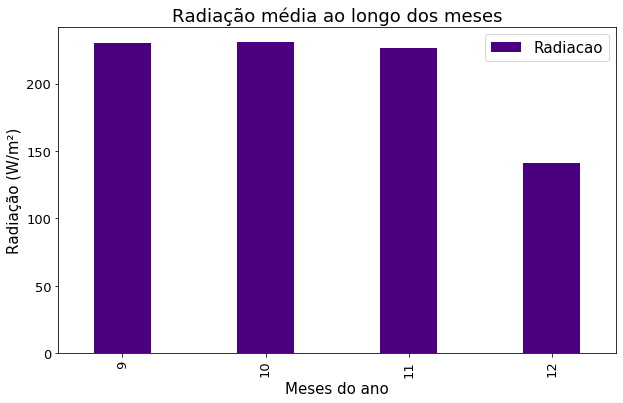

In [51]:
#Radiação média ao longo dos meses (Setembro até Dezembro)

plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 15})
lista_rad.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=13, width=0.4);
plt.title("Radiação média ao longo dos meses")
plt.xlabel("Meses do ano")
plt.ylabel("Radiação (W/m²)")
plt.legend()
plt.show()


In [52]:
#Radiação em um dia 
filtro_dia = dataframe.loc[:,'Dia'] == 12
filtro_mes = dataframe.loc[:,'Mes'] == 10

dia = dataframe.loc[filtro_dia & filtro_mes, ['Radiacao','Hora']]
dia.head(5)

,Radiacao,Hora
12849,1.25,23:55:23
12850,1.25,23:50:21
12851,1.25,23:45:25
12852,1.26,23:40:28
12853,1.23,23:35:22


In [53]:
dia["Hora"] = pd.to_datetime(dia['Hora']).dt.time
dia.head(5)

,Radiacao,Hora
12849,1.25,23:55:23
12850,1.25,23:50:21
12851,1.25,23:45:25
12852,1.26,23:40:28
12853,1.23,23:35:22


TypeError: float() argument must be a string or a number, not 'datetime.time'

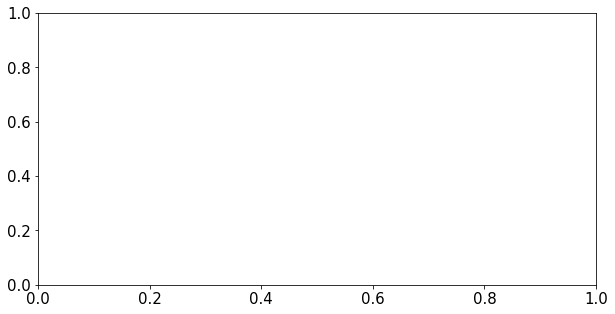

In [54]:
#Plotando o gráfico:

plt.figure(figsize=(10,5))
plt.plot(dia.Hora,dia.Radiacao, label='Radiacao', color='indigo', linewidth=2) 
plt.title("Radiação durante um dia")
plt.xlabel("Hora do dia")
plt.ylabel("Radiação (W/$m^2$)")
plt.legend()
plt.tight_layout()
plt.show()

### ❑ Análises mais gerais dos dados via heatmap:

In [55]:
#Fazendo um "pequeno" filtro para uma análise melhor dos dados, ou seja, pegando só variáveis quantitativas importantes:
heat = dataframe.loc[:,['Radiacao','TempGraus',
                        'Pressao(atm)','Umidade','DirVento','SenDirVen','CosDirVen','Velocidade']]
heat.head(5)

,Radiacao,TempGraus,Pressao(atm),Umidade,DirVento,SenDirVen,CosDirVen,Velocidade
0,1.21,8.888889,"(1.0503448275862068, 921)",59,177.39,0.109763,0.993958,9.04258
1,1.21,8.888889,"(1.0503448275862068, 921)",58,176.78,0.659373,0.751816,5.42233
2,1.23,8.888889,"(1.0503448275862068, 921)",57,158.75,-0.099407,0.995047,5.42233
3,1.21,8.888889,"(1.0503448275862068, 921)",60,137.71,0.867781,-0.496947,5.42233
4,1.17,8.888889,"(1.0503448275862068, 921)",62,104.95,-0.289164,-0.957279,9.04258


#### ▶ Pairplot:

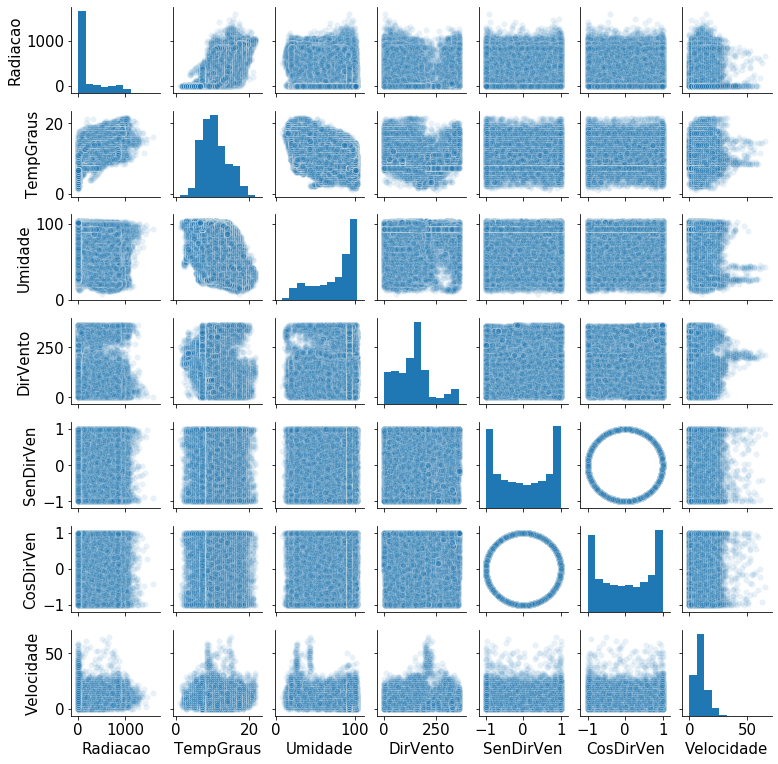

In [56]:
sns.pairplot(heat, height=1.5, plot_kws={'alpha':0.1});

#### ▶ Heatmap:

(7.5, -0.5)

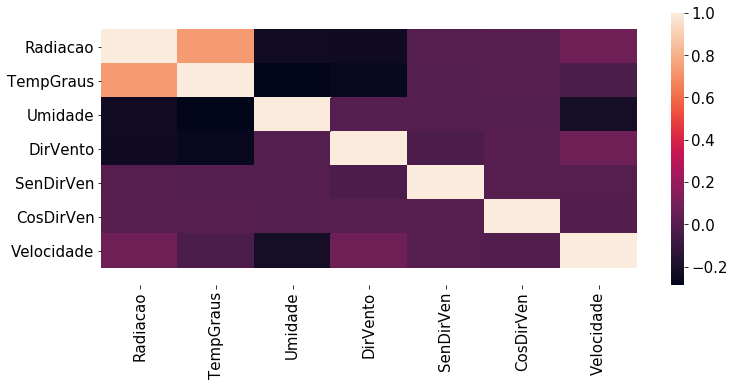

In [57]:
#Calcula coeficientes de correlação (matriz):
corr = heat.corr()

#Plotando mapa de calor e fazendo alguns ajustes 
plt.figure(figsize = (12,5))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
baixo, topo = ax.get_ylim()
ax.set_ylim(baixo + 0.5, topo - 0.5)

▶ O pairplot fornece uma visão geral dos dados, assim como o heatmap. A única diferença é na visualização dos dados (por scatter, ou por cores). 

▶ O heatmap analisa os coeficientes de correlação juntamente com cores, ou seja, o quão uma variável se relaciona/depende da outra. Nesse sentido, cores mais claras indicam relação positiva entre as colunas. Por sua vez, cores mais escuras indicam que as colunas tem relação mais negativa! 

▶ No caso , como nosso projeto visa **prever a radiação**, ela é a **variável que importa** relacionada a **outras features**. Isso é uma informação que será útil para os futuros modelos. Veja que, por exemplo, Radiação e Temperatura são as duas colunas que mais estão relacionadas positivamente do que algumas outras. Então a ideia dos modelos abaixo é entender qual o melhor modelo que encaixa a variável target, com a feature!

___

<div id="modelos"></div>

## > Modelos de Predição 

> Nessa parte foram usadas as funções auxiliares. Caso tenha alguma dúvida, veja nesse link as funções: [Funções Auxiliares](#funcoes)

In [58]:
#Aqui vou realizar um ajuste, já que o python não entende como usar uma TUPLA na regressão:
heat["Pressao(atm)f"] = heat['Pressao(atm)'].apply(getzero)
heat.head(5)

,Radiacao,TempGraus,Pressao(atm),Umidade,DirVento,SenDirVen,CosDirVen,Velocidade,Pressao(atm)f
0,1.21,8.888889,"(1.0503448275862068, 921)",59,177.39,0.109763,0.993958,9.04258,1.050345
1,1.21,8.888889,"(1.0503448275862068, 921)",58,176.78,0.659373,0.751816,5.42233,1.050345
2,1.23,8.888889,"(1.0503448275862068, 921)",57,158.75,-0.099407,0.995047,5.42233,1.050345
3,1.21,8.888889,"(1.0503448275862068, 921)",60,137.71,0.867781,-0.496947,5.42233,1.050345
4,1.17,8.888889,"(1.0503448275862068, 921)",62,104.95,-0.289164,-0.957279,9.04258,1.050345


In [59]:
#Separando em teste e treino:
X_antes = heat[['TempGraus','Pressao(atm)f','Umidade','SenDirVen','CosDirVen', 'Velocidade']]
Y_antes = heat['Radiacao']

X_train, X_test, y_train, y_test = train_test_split(X_antes, Y_antes, test_size=0.4, random_state=0)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19611, 6), (13075, 6), (19611,), (13075,))

### ❑ Descrição e aplicação do Modelo 1 (Treinamento) e validação (Teste):

O modelo de regressão linear, foi utilizado para definir uma relação entre uma variável dependente e independente.

#### ❑ Aplicação:

▶ O heatmap e o pairplot acima indicam que a radiação tem relação com a temperatura. Pelo pairplot suspeitamos que seja possível aproximar linearmente essas duas variáveis. No entanto, vamos usar todas as colunas na regressão e ir removendo elas para fazer uma análise mais detalhada (método Backward Stepwise). Essa remoção será baseada no valor p, com índice de confiança de 95%.

> Nessa parte foram usadas as funções auxiliares. Caso tenha alguma dúvida, veja nesse link as funções: [Funções Auxiliares](#funcoes)

In [61]:
X = X_train[['TempGraus','Pressao(atm)f','Umidade', 'SenDirVen','CosDirVen', 'Velocidade']]

#Usando todas as colunas 
results = regress(y_train, X)

# Mostra os resultados
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Radiacao   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     4219.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:22:45   Log-Likelihood:            -1.3260e+05
No. Observations:               19611   AIC:                         2.652e+05
Df Residuals:                   19604   BIC:                         2.653e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.048e+04    892.178     22.951      0.000    1.87e+04    2.22e+04
x1            70.6351      0.470    150.397      0.000      69.714      71.556
x2         -2.007e+04    850.475    -23.595      0.000   -2.17e+04   -1.84e+04
x3            -0.2109      0.063     -3.365      0.001      -0.334      -0.088
x4            -1.8954      2.097     -0.904      0.366      -6.005       2.214
x5             1.1796      2.128      0.554      0.579      -2.992       5.351
x6             4.8715      0.275     17.708      0.000       4.332       5.411
==============================================================================
Omnibus:                     1493.689   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2085.767
Skew:                           0.644   Prob(JB):                         0.00
Kurtosis:                       3.946   Cond. No.                     6.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Veja que a variável x4 e x5 estão com resultados ruins, então vamos remover a coluna CosDirVen e plotar novo modelo:

In [62]:
X2 = X_train[['TempGraus','Pressao(atm)f','Umidade','SenDirVen','Velocidade']]
results2 = regress(y_train, X2)

# Mostra os resultados
results2.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Radiacao   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     5062.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:22:45   Log-Likelihood:            -1.3260e+05
No. Observations:               19611   AIC:                         2.652e+05
Df Residuals:                   19605   BIC:                         2.653e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.048e+04    892.083     22.961      0.000    1.87e+04    2.22e+04
x1            70.6400      0.470    150.438      0.000      69.720      71.560
x2         -2.007e+04    850.384    -23.605      0.000   -2.17e+04   -1.84e+04
x3            -0.2110      0.063     -3.366      0.001      -0.334      -0.088
x4            -1.8849      2.097     -0.899      0.369      -5.994       2.225
x5             4.8702      0.275     17.705      0.000       4.331       5.409
==============================================================================
Omnibus:                     1492.702   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2084.006
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       3.946   Cond. No.                     6.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Veja que a variável x4 está com resultados ruins, então vamos remover a coluna SinDirVen e plotar novo modelo:

In [63]:
X3 = X_train[['TempGraus','Pressao(atm)f','Umidade','Velocidade']]
results3 = regress(y_train, X3)

# Mostra os resultados
results3.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Radiacao   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     6328.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        14:22:45   Log-Likelihood:            -1.3260e+05
No. Observations:               19611   AIC:                         2.652e+05
Df Residuals:                   19606   BIC:                         2.652e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.047e+04    891.971     22.950      0.000    1.87e+04    2.22e+04
x1            70.6367      0.470    150.436      0.000      69.716      71.557
x2         -2.006e+04    850.276    -23.594      0.000   -2.17e+04   -1.84e+04
x3            -0.2110      0.063     -3.366      0.001      -0.334      -0.088
x4             4.8691      0.275     17.701      0.000       4.330       5.408
==============================================================================
Omnibus:                     1492.678   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2084.097
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       3.946   Cond. No.                     6.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Todas as demais estão com valor p igual a zero, ou próximo dele, indicando relação. Chegamos ao final da remoção de colunas.

#### ❑ Validação:

In [64]:
#Fazendo comparação:  
X_testc = sm.add_constant(X_test[['TempGraus','Pressao(atm)f','Umidade','Velocidade']].values)

y_pred = results3.predict(X_testc)

In [65]:
r2_linear = r2_score(y_test, y_pred) 
mean_sq_linear = mean_squared_error(y_test, y_pred)**(1/2)
mean_ab_linear = mean_absolute_error(y_test, y_pred)
r2_linear, mean_sq_linear, mean_ab_linear

print('R² =',r2_linear)
print('Média do quadrado dos erros =', mean_sq_linear)
print('Média absoluta dos erros=', mean_ab_linear)

R² = 0.5582198172697003
Média do quadrado dos erros = 209.49407882589688
Média absoluta dos erros= 158.6159008399494



- O erro quadrático medio tem a função de comparar as variâncias de estimadores, assim analisando se estão ou não viciados, ou seja replicando resultados previamente estimados.


- O erro médio absoluto é uma medida que em um conjunto de observações de um mesmo fenômeno, observa erros

- O R², também chamado de Coeficiente de Determinação, diz o quanto o modelo está prevendo corretamente, sendo o valor mais alto igual a 1 e o valor mais baixo igual a 0.

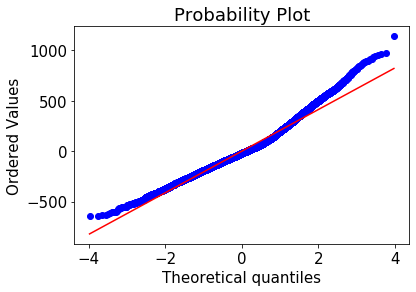

In [66]:
#Probplot do modelo 3:  
stats.probplot(results3.resid, dist='norm', plot=plt);

- Os resíduos se aproximam mais ou menos de uma distribuição normal, como demonstrado pelo gráfico probabilístico mostrado anteriormente.

### ❑ Descrição e aplicação do Modelo 2 (Treinamento) e validação (Teste) - Decision Tree:

Utilizamos o modelo Decision Tree para a 2ª aplicação. Este modelo, quando usado para problemas de regressão, tem o objetivo de prever um número. Para isso a árvore utilizará os conceitos de média e desvio padrão, que possibilitarão um resultado final numérico.

In [67]:
#Criando o classificador
dt = DecisionTreeRegressor()

#Treinando o modelo
dt = dt.fit(X_train, y_train)

In [68]:
dt_pred = dt.predict(X_test)

In [69]:
r2_dt = r2_score(y_test, dt_pred)
mean_sq_dt = mean_squared_error(y_test, dt_pred)**(1/2)
mean_ab_dt = mean_absolute_error(y_test, dt_pred)
r2_dt, mean_sq_dt, mean_ab_dt

print('R² =',r2_dt)
print('Média do quadrado dos erros =', mean_sq_dt)
print('Média absoluta dos erros=', mean_ab_dt)

R² = 0.4273565873305556
Média do quadrado dos erros = 238.51229533211944
Média absoluta dos erros= 124.16462541746336


### ❑ Descrição e aplicação do Modelo 3 (Treinamento) e validação (Teste) - Random Forest:

Utilizamos o modelo de Regressão Random Forest para a 3ª aplicação. O Random Forest interpreta de maneira aleatória, diferentes modelos, buscando as melhores condições para a análise.

#### ❑ Aplicação do modelo, validação e análises:

In [70]:
#Criando o classificador
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1)

#Treinando o modelo
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
#Usando o modelo para prever e depois comparar
previsao = rf.predict(X_test)

#Validação
r2_rf = r2_score(y_test, previsao)
mean_sq_rf = mean_squared_error(y_test, previsao)**(1/2)
mean_ab_rf = mean_absolute_error(y_test, previsao)
r2_rf, mean_sq_rf, mean_ab_rf

print('R² =',r2_rf)
print('Média do quadrado dos erros =', mean_sq_rf)
print('Média absoluta dos erros=', mean_ab_rf)

R² = 0.6911156471988007
Média do quadrado dos erros = 175.17276762990556
Média absoluta dos erros= 103.69625212149079


___

<div id="conclusao"></div>

## > Conclusão 

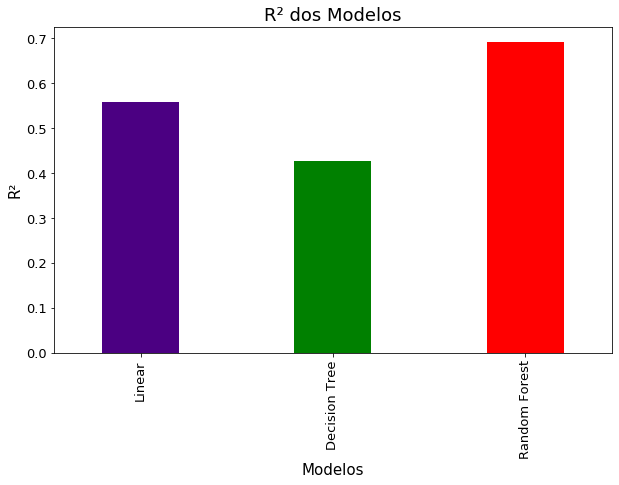

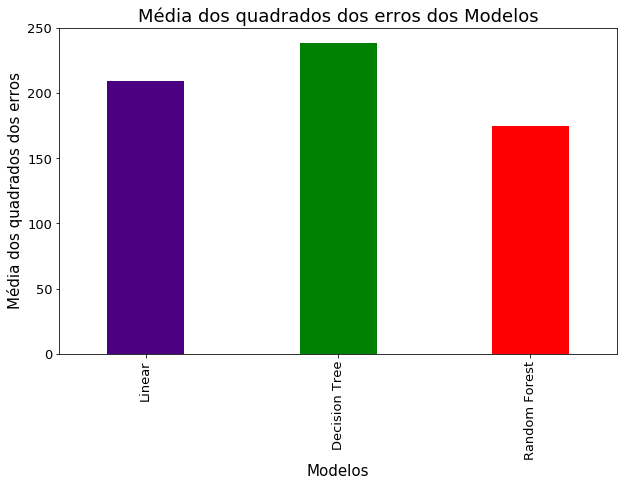

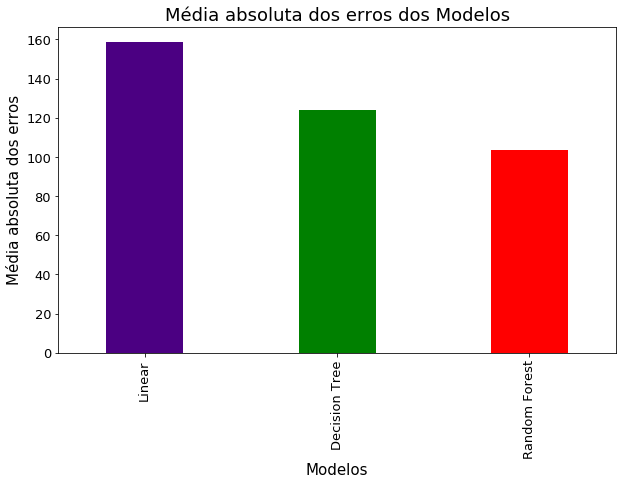

In [73]:
#R2 dos 3 modelos
lista_r2 = [r2_linear, r2_dt, r2_rf]
lista_mean_sq = [mean_sq_linear, mean_sq_dt, mean_sq_rf]
lista_mean_ab = [mean_ab_linear, mean_ab_dt, mean_ab_rf]


df_r2 = pd.DataFrame (lista_r2)
bars = ('Linear', 'Decision Tree', 'Random Forest')
y_pos = np.arange(len(bars))
df_r2.plot(kind='bar', figsize=(10,6), color=("indigo","green","red"), fontsize=13, width=0.4, legend=False)
plt.title("R² dos Modelos")
plt.xlabel("Modelos")
plt.xticks(y_pos, bars)
plt.ylabel("R²")
plt.show()

df_mean_sq = pd.DataFrame (lista_mean_sq)
bars = ('Linear', 'Decision Tree', 'Random Forest')
y_pos = np.arange(len(bars))
df_mean_sq.plot(kind='bar', figsize=(10,6), color=("indigo","green","red"), fontsize=13, width=0.4, legend=False)
plt.title("Média dos quadrados dos erros dos Modelos")
plt.xlabel("Modelos")
plt.xticks(y_pos, bars)
plt.ylabel("Média dos quadrados dos erros")
plt.show()

df_mean_ab = pd.DataFrame (lista_mean_ab)
bars = ('Linear', 'Decision Tree', 'Random Forest')
y_pos = np.arange(len(bars))
df_mean_ab.plot(kind='bar', figsize=(10,6), color=("indigo","green","red"), fontsize=13, width=0.4, legend=False)
plt.title("Média absoluta dos erros dos Modelos")
plt.xlabel("Modelos")
plt.xticks(y_pos, bars)
plt.ylabel("Média absoluta dos erros")
plt.show()


O modelo 3, ou seja, o modelo de Random Forest foi o melhor modelo usado na predição do comportamento da radiação, uma vez que o seu R² é o que mais se aproxima de 1, e é o modelo com menos erros, como se percebe ao comparar as médias dos quadrados de seus erros e dos seus erros absolutos com as médias dos modelos Linear e Decision Tree. Isso fica explícito nos gráficos apresentados anteriormente, onde a visualização desses dados está mais fácil.


<div id="referencias"></div>

## > Referências Bibliográficas 

- https://stackoverflow.com/questions/39409866/correlation-heatmap
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://www.dataquest.io/blog/python-datetime-tutorial/
- https://www.tutorialspoint.com/How-to-convert-unix-timestamp-string-to-readable-date-in-Python
- https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
- https://www.ime.usp.br/~fmachado/MAE229/AULA10.pdf
- https://pt.wikipedia.org/wiki/Erro_quadr%C3%A1tico_m%C3%A9dio
- https://en.wikipedia.org/wiki/Mean_absolute_error